In [1]:
import numpy as np
import twint
import matplotlib.pyplot as plt
import pandas as pd
import re
from random import randrange

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nest_asyncio
nest_asyncio.apply()

import nltk
nltk.download(['stopwords'])
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import itertools, collections
from nltk import bigrams

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\popov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
gallup_tobacco_data = [19, 21, 19, 19, 17, 16, 15]
gallup_cannabis_data = [44, 50, 46, 58, 52, 58, 60, 64, 66, 64, 68]

In [3]:
years = [f"{x:02d}" for x in range(2010, 2021)]
search_terms = ['Cannabis', 'Ganja', 'Marijuana']
file_name = 'cannabis/Cannabis'

#years = [f"{x:02d}" for x in range(2013, 2020)]
#search_terms = ['smoking cigarettes', 'tobacco']
#file_name = 'tobacco/Tobacco'

In [4]:
def get_yearly_statistics(year, file_name):

    df_all = pd.read_csv(file_name + year + '.csv')
    df_all.drop(['conversation_id', 'created_at', 'time', 'timezone', 'user_id', 'username', 'name', 'place', 'mentions', 'urls', 'photos', 'cashtags', 'link', 'retweet', 'quote_url', 'video', 'user_rt_id', 'near', 'geo', 'thumbnail', 'language', 'source', 'user_rt', 'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src', 'trans_dest'], axis = 1, inplace = True)

    additional_symbols = ['via', '(via', '-', 'rt', '"', '“', '@', '::']
    
    df_all['clean'] = df_all['tweet'] \
        .apply(lambda x: re.sub(r"(?:\@|https?\://)\S+", "", x)) \
        .apply(lambda x: ' '.join([item for item in x.lower().split() if item not in stopwords and item not in additional_symbols]))

    df = df_all.drop_duplicates('clean').sort_index()
    df['shop'] = df['hashtags'].apply(lambda x: 'shop' in x)
    res_df = df[df['shop'] == False]

    analyzer = SentimentIntensityAnalyzer()
    res_df['vader_score'] = res_df['clean'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

    pos_num = len(res_df[res_df['vader_score'] >= 0.05])
    neg_num = len(res_df[res_df['vader_score'] <= -0.05])
    
    #return pos_num/len(res_df) * 100
    return pos_num/(pos_num + neg_num) * 100

In [5]:
results = [get_yearly_statistics(year, file_name) for year in years]

<ipython-input-4-af75fba2d195>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df['vader_score'] = res_df['clean'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


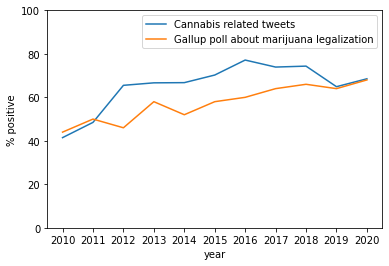

change in total: 27.06 24
change in last year: 3.63 4


In [6]:
plt.plot(years, results, label = "Cannabis related tweets")
plt.plot(years, gallup_cannabis_data, label = "Gallup poll about marijuana legalization")

#plt.plot(years, results, label = "Tobacco related tweets")
#plt.plot(years, gallup_tobacco_data, label = "Gallup poll 'Have you smoked recently?'")

plt.xlabel('year')
plt.ylabel('% positive')
axes = plt.gca()
axes.set_ylim([0, 100])

plt.rcParams["figure.figsize"] = 7,5
plt.legend()
plt.show()

print('change in total:', "{:.2f}".format(results[-1] - results[0]), gallup_cannabis_data[-1] - gallup_cannabis_data[0])
print('change in last year:', "{:.2f}".format(results[-1] - results[-2]), gallup_cannabis_data[-1] - gallup_cannabis_data[-2])

#print('change in total:', "{:.2f}".format(results[-1] - results[0]), gallup_tobacco_data[-1] - gallup_tobacco_data[0])

In [7]:
years = [f"{x:02d}" for x in [2010, 2020]]
file_name = 'cannabis/Cannabis'

#years = [f"{x:02d}" for x in [2013, 2019]]
#file_name = 'tobacco/Tobacco'

In [8]:
def get_top_bigrams(year, file_name):
    df_all = pd.read_csv(file_name + year + '.csv') \
        .drop_duplicates('tweet').sort_index()
    df_all.drop(['conversation_id', 'created_at', 'time', 'timezone', 'user_id', 'username', 'name', 'place', 'mentions', 'urls', 'photos', 'cashtags', 'link', 'retweet', 'quote_url', 'video', 'user_rt_id', 'near', 'geo', 'thumbnail', 'language', 'source', 'user_rt', 'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src', 'trans_dest'], axis = 1, inplace = True)

    additional_symbols = ['via', '(via', '-', 'rt', '"', '“', '@', '::']

    df_all['clean'] = df_all['tweet'] \
        .apply(lambda x: re.sub(r"(?:\@|https?\://)\S+", "", x)) \
        .apply(lambda x: [item for item in x.lower().split() if item not in stopwords and item not in additional_symbols])

    df = df_all.dropna(subset=['clean'])
    
    df['shop'] = df['hashtags'].apply(lambda x: 'shop' in x)
    res_df = df[df['shop'] == False]

    tweets = res_df['clean'].tolist()
    all_bigrams = list(itertools.chain(*[list(bigrams(tweet)) for tweet in tweets]))
    top_bigrams = [' '.join(bigram[0]) for bigram in collections.Counter(all_bigrams).most_common(9)]

    return (top_bigrams)

In [9]:
res = [get_top_bigrams(year, file_name) for year in years]
res

[['medical marijuana',
  'pounds marijuana',
  'synthetic marijuana',
  'marijuana dispensary',
  'marijuana plants',
  'possession marijuana',
  'marijuana possession',
  'traffic stop',
  'man arrested'],
 ['medical marijuana',
  'recreational marijuana',
  'legalize marijuana',
  'medical cannabis',
  'ganja white',
  'cannabis industry',
  'top shelf',
  'white night',
  'menu snapchat::👻']]

In [10]:
years = ['2010', '2014', '2016', '2020']
file_name = 'Cannabis'

In [11]:
def get_users_statistics(year, file_name):
    df_users = pd.read_csv('users/Users' + file_name + year + '.csv')
    df = df_users.drop_duplicates('id').sort_index()
    return (len(df[df['verified'] == True]) * 100 / df['id'].count(), df['followers'].mean())

In [12]:
verified, followers = zip(*[get_users_statistics(year, file_name) for year in years])

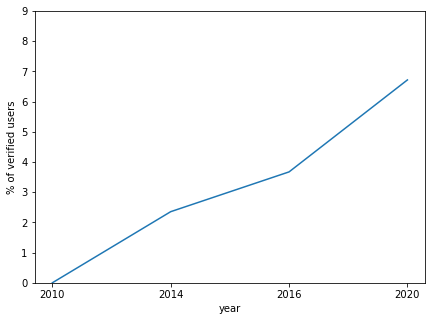

In [13]:
plt.plot(years, verified)

plt.xlabel('year')
plt.ylabel('% of verified users')
axes = plt.gca()
axes.set_ylim([0, 9])
plt.rcParams["figure.figsize"] = 4,3

plt.show()

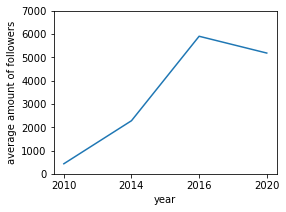

In [14]:
plt.plot(years, followers)

plt.xlabel('year')
plt.ylabel('average amount of followers')
axes = plt.gca()
axes.set_ylim([0, 7000])
plt.rcParams["figure.figsize"] = 4,3

plt.show()